In [1]:
import numpy as np
import math
from activation_functions import *
from get_data import get_dataset

import matplotlib.pyplot as plt

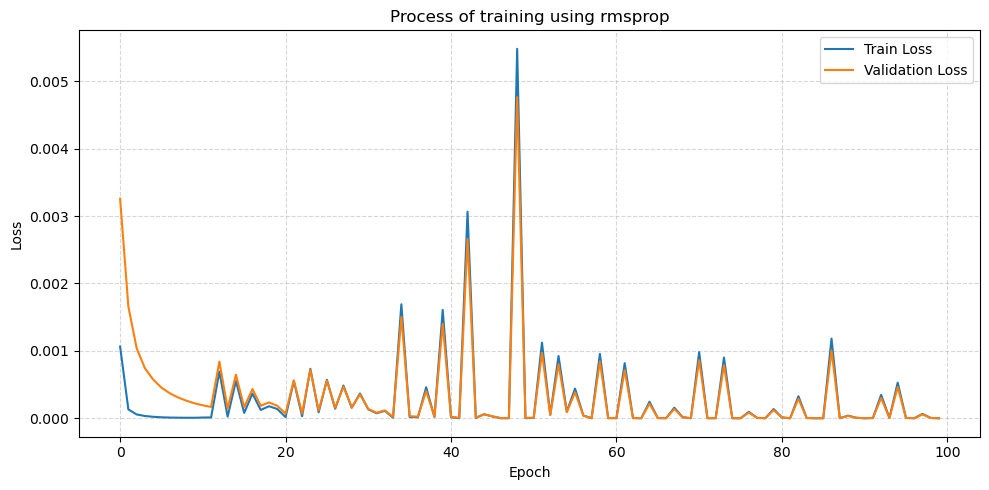

In [15]:
def onehot(y):
    y_oh = np.zeros((y.size, y.max() + 1))
    y_oh[np.arange(y.size), y] = 1
    return y_oh

class NeauralNetwork:
    def __init__(self, size: list,
                 lr: float = 0.001,
                 batch_size: int = 32,
                 epoch: int = 100,
                 activation_functions: list = None,
                 optimizer: str = None,
                 task_type: str = "classification"):
        
        self.size = size
        self.learning_rate = lr
        self.batch_size = batch_size
        self.epoch = epoch
        self.optimizer = optimizer
        
        if task_type == "classification":
            self.last_act_function = softmax
            self.last_derivative = dsoftmax
            self.loss_function = self.cross_entropy
        elif task_type == "regression":
            self.last_act_function = linear
            self.last_derivative = 1
            self.loss_function = self.mse
        else:
            raise ValueError("")
        self.task_type = task_type
        self.loss_function_name = self.loss_function.__name__
        
        self.W = [np.random.randn(size[i], size[i+1]) for i in range(len(size)-1)]
        self.b = [np.zeros((size[i+1], ))for i in range(len(size)-1)]
        self.layers = self._create_layers(activation_functions)
        
        #monumentum values
        self.v_w = [np.zeros_like(w) for w in self.W]
        self.v_b = [np.zeros_like(b) for b in self.b]
        #rmsprop values
        self.s_w = [np.zeros_like(w) for w in self.W]
        self.s_b = [np.zeros_like(b) for b in self.b]
        
        #self.a = []
        #self.z = []
        #self.derivatives = []
                
    def _create_layers(self, act_fs: list = None):
        if act_fs is None:
            act_fs = [sigmoid] * len(self.W)
        assert len(act_fs) == len(self.W), ""
        assert len(act_fs) == len(self.b), ""
        
        layers = []
        derivatives_fs = []
        for i in range(len(act_fs)):
            #check act_fs
            layer = [self.W[i], self.b[i], act_fs[i]]
            
            if i == len(act_fs) - 1:
                derivatives_fs.append(self.last_act_function)
            elif act_fs[i] is sigmoid:
                derivatives_fs.append(dsigmoid)
            elif act_fs[i] is tanh:
                derivatives_fs.append(dtanh)
            elif act_fs[i] is relu:
                derivatives_fs.append(drelu)
            else:
                raise ValueError(f"The activation function is unsupported: {act_fs[i]}")
            
            layers.append(layer)
        self.derivatives = derivatives_fs
        return layers
    
    def forward(self, X):
        a = [X.copy()]
        z = []
        A = a[-1]
        for layer in self.layers:
            W, b, actf = layer
            Z = A @ W + b
            z.append(Z)
            if layer is self.layers[-1]:
                actf = self.last_act_function
            A = actf(Z)
            a.append(A)
            
        self.a = a
        self.z = z
        return A
    
    def mse(self, X, y):
        y_pred = self.forward(X)
        assert y.shape == y_pred.shape, f"Shape mismatch: {y.shape} vs {y_pred.shape}"
        return 0.5 * np.mean((y_pred - y)**2)
    
    def cross_entropy(self, X, y):
        epsilon = 1e-9
        y_pred = self.forward(X)
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        return -np.mean(y * np.log(y_pred))
    
    def _compute_grad(self, X, y):
        m = len(X)
        A = self.forward(X)
        delta = (A - y)
        grads_w, grads_b = [], []
        L = len(self.W) - 1
        for i in range(L, -1, -1):
            grad_w = np.dot(self.a[i].T, delta)
            grad_b = np.sum(delta, axis=0)
            grads_w.append(grad_w)
            grads_b.append(grad_b)

            if i > 0: #prevent before i = -1
                delta = np.dot(delta, self.W[i].T) * self.derivatives[i-1](self.z[i-1])
        return grads_w[::-1], grads_b[::-1]
    
    def sgd_update(self, gradients_w, gradients_b, lr, *args):
        for i in range(len(self.W)):
            self.W[i] -= lr * gradients_w[i]
            self.b[i] -= lr * gradients_b[i]
            
    def monumentum_upgrade(self, gradients_w, gradients_b, lr, beta):
        for i in range(len(self.W)):
            self.v_w[i] = beta * self.v_w[i] + gradients_w[i] # velocity (monumentum) for weights
            self.v_b[i] = beta * self.v_b[i] + gradients_b[i] # velocity (monumentum) for bias
            self.W[i] -= lr * self.v_w[i]
            self.b[i] -= lr * self.v_b[i]
            
    def rmsprop_upgrade(self, gradients_w, gradients_b, lr, gamma):
        epsilon = 1e-6
        for i in range(len(self.W)):
            self.s_w[i] = gamma*self.s_w[i]+ (1-gamma)*gradients_w[i]**2
            self.s_b[i] = gamma*self.s_b[i] + (1-gamma)*gradients_b[i]**2
            self.W[i] -= lr*gradients_w[i]/(np.sqrt(self.s_w[i] + epsilon))
            self.b[i] -= lr*gradients_b[i]/(np.sqrt(self.s_b[i] + epsilon))
            
    def adam_upgrade(self, gradients_w, gradients_b, lr, beta, gamma):
        #implement later
        pass
            
    def _init_optimizing_function(self, optimizer_name, beta, gamma):
        if optimizer_name == "SGD":
            self.upgrade_weights_function = lambda gw, gb, lr: self.sgd_update(gw, gb, lr)
        elif optimizer_name == "monumentum":
            self.upgrade_weights_function = lambda gw, gb, lr: self.monumentum_upgrade(gw, gb, lr, beta)
        elif optimizer_name == "rmsprop":
            self.upgrade_weights_function = lambda gw, gb, lr: self.rmsprop_upgrade(gw, gb, lr, gamma)
        else:
            raise ValueError(f"The given optimizer is unsupported: {self.optimizer}")
    
    def train(self, X, y,
              optimizer: str = None,
              beta: float = 0.9,
              gamma: float = 0.99,
              split: bool = False,
              train_size: float = 0.7,
              test_size: float = 0.3,
              X_valid=None,
              y_valid=None,
              random_seed = 15,
              show_training: bool = True,
              n_last_epochs: int = 0
              ):
        
        if self.task_type == "classification" and not (y.shape == (len(X), self.size[-1])):
            y = onehot(y)
        
        np.random.seed(random_seed)
        if self.optimizer is None and optimizer is None:
            self.optimizer = "SGD"
        elif self.optimizer is None:
            self.optimizer = optimizer
        self._init_optimizing_function(self.optimizer, beta, gamma)
            
        p = np.random.permutation(len(X))
        pX, py = X[p], y[p]
        
        train_losses = []
        valid_losses = []
        
        if split and X_valid is None and y_valid is None:
            n = int(len(pX) * train_size)
            X_valid = pX[n:]; y_valid = py[n:]
            pX = pX[:n]; py = py[:n]
            
        for epoch in range(self.epoch):
            for batch in range(0, len(pX), self.batch_size):
                X_train = pX[batch : batch + self.batch_size]
                y_train = py[batch : batch + self.batch_size]
                gradients_w, gradients_b = self._compute_grad(X_train, y_train)
                self.upgrade_weights_function(gradients_w, gradients_b, self.learning_rate)
            train_loss = self.loss_function(X_train, y_train)
            
            train_losses.append(train_loss)
            if split or (X_valid is not None and y_valid is not None):
                valid_loss = self.loss_function(X_valid, y_valid)
                valid_losses.append(valid_loss)
        
        if show_training:
            self.plot_training_process(train_losses, valid_losses, n_last_epochs)
            
        return train_losses, valid_losses
    
    def plot_training_process(self, train_losses, valid_losses, n_last_epochs, **plot_kwargs):
        assert len(train_losses) == len(valid_losses), (
            f"train_losses and valid_losses must have the same length "
            f"({len(train_losses)} != {len(valid_losses)})"
        )
        train_losses_sample = train_losses[-n_last_epochs: ]
        valid_losses_sample = valid_losses[-n_last_epochs: ]

        epochs = list(range(len(train_losses_sample)))
        fig, ax = plt.subplots(figsize=plot_kwargs.pop("figsize", (10, 5)))

        ax.plot(epochs, train_losses_sample, label="Train Loss", **plot_kwargs)
        ax.plot(epochs, valid_losses_sample, label="Validation Loss", **plot_kwargs)

        ax.set_title(f"Process of training using {self.optimizer}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend()

        plt.tight_layout()
        plt.show()

        return fig, ax


#X1 = np.random.randn(500, 3) * 0.2 + np.array([-0.5, -0.5, -0.5])
#X2 = np.random.randn(500, 3) * 0.2 + np.array([0.5, 0.5, 0.5])
#X = np.vstack([X1, X2])
#y = np.hstack([np.zeros(500), np.ones(500)]).astype(np.int16)
n_features = 5
X, y = get_dataset("blobs", n_features=n_features)
y = y.reshape(-1, 1)
np.random.seed(15)
p = np.random.permutation(len(X))
X, y = X[p], y[p]
nn = NeauralNetwork([n_features, 10, 1], lr=0.01, epoch=100, optimizer="rmsprop", task_type="regression", activation_functions=[tanh, linear])
train_losses, valid_losses = nn.train(X, y, split=True)

In [10]:
train_losses

[np.float64(0.7681510839565112),
 np.float64(0.01081971037079253),
 np.float64(0.03250968852908396),
 np.float64(0.10635586581857899),
 np.float64(0.005819436966100368),
 np.float64(0.0030537930355424257),
 np.float64(0.022055728343881663),
 np.float64(0.0027466268994259706),
 np.float64(0.00161292290922254),
 np.float64(0.0015827047588490982),
 np.float64(0.020579197741765635),
 np.float64(0.00014721685172623434),
 np.float64(0.0028407098613844584),
 np.float64(0.057706855829882116),
 np.float64(0.007499780277660324),
 np.float64(0.0018393179501906942),
 np.float64(0.004662714412710301),
 np.float64(0.0006449595230811225),
 np.float64(8.250974919454938e-06),
 np.float64(4.587682776872039e-06),
 np.float64(1.2436747835109347e-07),
 np.float64(2.755914533321032e-07),
 np.float64(4.493468940358539e-08),
 np.float64(1.231233273188898e-08),
 np.float64(1.689486306771306e-08),
 np.float64(1.5269825434690894e-08),
 np.float64(1.1207126952963666e-08),
 np.float64(9.206448219263639e-09),
 np.f

In [11]:
valid_losses

[np.float64(0.9056737048596043),
 np.float64(0.03288893993093304),
 np.float64(0.04641050456126749),
 np.float64(0.10778523461692426),
 np.float64(0.015496039881029775),
 np.float64(0.009049600831460303),
 np.float64(0.029810328326120572),
 np.float64(0.006352340110283604),
 np.float64(0.016131794622797502),
 np.float64(0.007101556688200138),
 np.float64(0.031499652888324584),
 np.float64(0.00017471506894795193),
 np.float64(0.007139123357643829),
 np.float64(0.03716001142123582),
 np.float64(0.009176163456674515),
 np.float64(0.012991289087063308),
 np.float64(0.012054412775948568),
 np.float64(0.007040105601259165),
 np.float64(0.0066306407081628774),
 np.float64(0.006686587477538771),
 np.float64(0.0066629176358964795),
 np.float64(0.0066543042276029),
 np.float64(0.00665699364726226),
 np.float64(0.006658382093629161),
 np.float64(0.006657763535272425),
 np.float64(0.006657772183142095),
 np.float64(0.00665793126913487),
 np.float64(0.006657981918872168),
 np.float64(0.006658019536